You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>
Using 20200408 Chou's data, unit2.<br>

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy import ndimage
from scipy.io import loadmat
import os
import pandas as pd
%matplotlib inline

In [16]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from NGD_TK_AS import NGD2L_TK_AS

importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# Load Experimental data

## select files and channels

In [4]:
loadfiles = np.load('D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\TKfit\\unit2_fitNGD2LASpara.npz', allow_pickle=True)

-0.007096342185162675


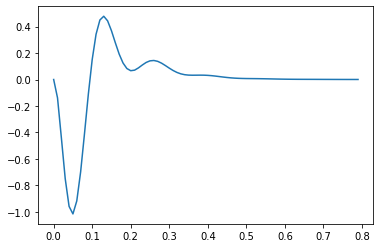

In [31]:
cn = 53
dt = 0.01
TKtaxis = np.arange(0,0.8,dt)
[epsilon, gamma, omegastar, deltastar, tau, Dmp] = pd.DataFrame(loadfiles['para_dict'][()]).loc[cn-1][:-1]
TK = NGD2L_TK_AS(TKtaxis, epsilon, gamma, omegastar, deltastar, tau, Dmp)

plt.plot(TKtaxis, TK)
longTK = np.append(np.zeros(len(TK)-1), TK)
print(sum(TK)*dt)

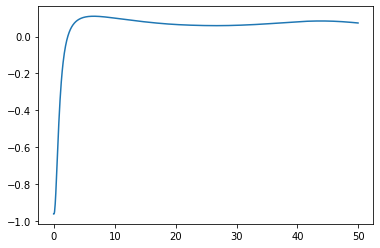

In [6]:
dOmega = 0.05
omega = np.arange(-dOmega ,50,dOmega)
F_TK = np.sum(TK[np.newaxis,:]*np.exp(-1j*TKtaxis[np.newaxis,:]*omega[:,np.newaxis]), axis = 1)*dt
Phi = np.angle(F_TK)
delta = -angular_gradient(Phi)/dOmega
plt.plot(omega, delta)

In [53]:
Fc_list = [10]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2' for Fc in Fc_list]

x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', [cn])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][cn-1,:]

# Real Spike

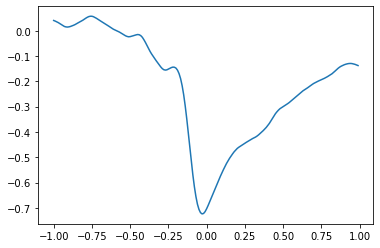

In [54]:
Xcorr = np.correlate(x_list[0], rstate_list[0], 'same')/np.correlate(np.ones_like(x_list[0]), rstate_list[0], 'same')
Xcorr = Xcorr[int(len(Xcorr)/2)-100:int(len(Xcorr)/2)+100]
T = np.arange(-1,1,dt)
plt.plot(T, Xcorr)

# Fake Spike from TK

In [55]:
def NGDXcorr(x, epsilon, gamma, omegastar, deltastar, tau, Dmp, Amp):
    dt = 0.01
    dt = dt/50
    T = np.arange(0, 1+dt, dt)
    Kd = T/tau /tau *np.exp(-T/tau)*dt
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-T*epsilon)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    TK = np.convolve(Kd, Kw, 'full')[:len(T):50]
    output = np.convolve(x*2+10, TK, 'full')[:len(x)]*dt
    
    Xcorr = (np.correlate(x, NL(output,np.mean(output)), 'same') 
           /np.correlate(np.ones_like(x), NL(output,np.mean(output)),  'same')   )
    Xcorr = Xcorr[int(len(Xcorr)/2)-100:int(len(Xcorr)/2)+100]
    return Amp*Xcorr

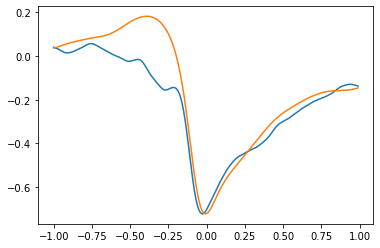

In [56]:
plt.plot(T, Xcorr)
tempNGDXcorr = NGDXcorr(x_list[0], epsilon, gamma, omegastar, deltastar, tau, Dmp, 1)
plt.plot(T, tempNGDXcorr/min(tempNGDXcorr)*min(Xcorr))

In [57]:
from scipy.optimize import curve_fit
popt,pcov = curve_fit(NGDXcorr, x_list[0] , Xcorr, p0=[epsilon, gamma, omegastar, deltastar, tau,  Dmp, 1],
                      bounds = ([0     , 0     , 0     ,-np.pi, 0     , 0     , 0],
                                [np.inf, np.inf, np.inf, np.pi, 0.6   , np.inf, np.inf]) )

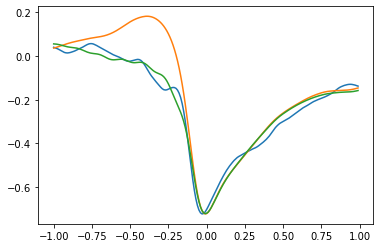

In [64]:
plt.plot(T, Xcorr)
tempNGDXcorr = NGDXcorr(x_list[0], epsilon, gamma, omegastar, deltastar, tau, Dmp, 1)
plt.plot(T, tempNGDXcorr/min(tempNGDXcorr)*min(Xcorr))
plt.plot(T, NGDXcorr(x_list[0], *popt))

# plt.xlim([-0.25, 0.25])
# plt.ylim([-1.1, -0.8])

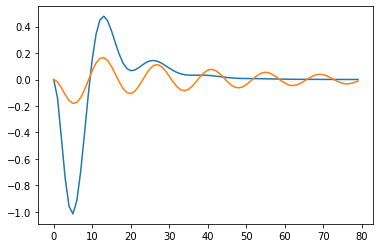

In [71]:
plt.plot(NGD2L_TK_AS(TKtaxis, epsilon, gamma, omegastar, deltastar, tau, Dmp))
plt.plot(NGD2L_TK_AS(TKtaxis, *popt[:-1])/1E5)

In [65]:
[epsilon, gamma, omegastar, deltastar, tau,  Dmp, 1]

[14.21752260168503,
 73996.44827916373,
 44.71177417255565,
 0.2852045041444931,
 0.0710354705187542,
 17.541823541715083,
 1]

In [70]:
popt

array([ 2.31079068e+00,  1.22749953e+05,  4.45747363e+01, -6.24062282e-03,
        6.51736064e-02,  1.78024145e+05,  7.44036297e-01])